In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-4/submission.csv
/kaggle/input/covid19-global-forecasting-week-4/test.csv
/kaggle/input/covid19-global-forecasting-week-4/train.csv
/kaggle/input/population-by-country-2020/population_by_country_2020.csv


In [2]:
pip install pycountry_convert

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import pycountry_convert as pc
import pycountry
import functools

In [4]:
train_df=pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
test_df=pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")

In [5]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26292 entries, 0 to 26291
Data columns (total 6 columns):
Id                26292 non-null int64
Province_State    11172 non-null object
Country_Region    26292 non-null object
Date              26292 non-null object
ConfirmedCases    26292 non-null float64
Fatalities        26292 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13459 entries, 0 to 13458
Data columns (total 4 columns):
ForecastId        13459 non-null int64
Province_State    5719 non-null object
Country_Region    13459 non-null object
Date              13459 non-null object
dtypes: int64(1), object(3)
memory usage: 420.7+ KB


In [8]:
print("Min train date: ",train_df["Date"].min())
print("Max train date: ",train_df["Date"].max())
print("Min test date: ",test_df["Date"].min())
print("Max test date: ",test_df["Date"].max())

Min train date:  2020-01-22
Max train date:  2020-04-14
Min test date:  2020-04-02
Max test date:  2020-05-14


In [9]:
pop_info = pd.read_csv("../input/population-by-country-2020/population_by_country_2020.csv")
#Population Data

In [10]:
pop_info.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438116346,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377011281,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,330578810,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,272884327,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,219922471,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [11]:
pop_info.rename(columns={'Density (P/Km²)': 'Density'}, inplace=True)

In [12]:
pop_info.columns

Index(['Country (or dependency)', 'Population (2020)', 'Yearly Change',
       'Net Change', 'Density', 'Land Area (Km²)', 'Migrants (net)',
       'Fert. Rate', 'Med. Age', 'Urban Pop %', 'World Share'],
      dtype='object')

In [13]:
country_lookup=pop_info[["Country (or dependency)","Population (2020)","Density","Med. Age","Urban Pop %"]]

In [14]:
country_lookup.head()

,Country (or dependency),Population (2020),Density,Med. Age,Urban Pop %
0,China,1438116346,153,38,61 %
1,India,1377011281,464,28,35 %
2,United States,330578810,36,38,83 %
3,Indonesia,272884327,151,30,56 %
4,Pakistan,219922471,287,23,35 %


In [15]:
pd.DataFrame.from_dict(country_lookup)
train_df_pop=pd.merge(train_df, country_lookup, how='left', left_on='Country_Region', right_on='Country (or dependency)')
#Train data joined with population data

In [16]:
train_df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26292 entries, 0 to 26291
Data columns (total 11 columns):
Id                         26292 non-null int64
Province_State             11172 non-null object
Country_Region             26292 non-null object
Date                       26292 non-null object
ConfirmedCases             26292 non-null float64
Fatalities                 26292 non-null float64
Country (or dependency)    20580 non-null object
Population (2020)          20580 non-null float64
Density                    20580 non-null float64
Med. Age                   20580 non-null object
Urban Pop %                20580 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 2.4+ MB


In [17]:
#Some of the names don't match with the file, hence manually setting them
train_df_pop.loc[train_df_pop["Country_Region"]=="US", ["Population (2020)"]]=331002651 #United Sates
train_df_pop.loc[train_df_pop["Country_Region"]=="US", ["Density"]]=36
train_df_pop.loc[train_df_pop["Country_Region"]=="US", ["Med. Age"]]=38
train_df_pop.loc[train_df_pop["Country_Region"]=="US", ["Urban Pop %"]]="83%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Burma", ["Population (2020)"]]=54409800 #Myanmar
train_df_pop.loc[train_df_pop["Country_Region"]=="Burma", ["Density"]]=83
train_df_pop.loc[train_df_pop["Country_Region"]=="Burma", ["Med. Age"]]=29
train_df_pop.loc[train_df_pop["Country_Region"]=="Burma", ["Urban Pop %"]]="39%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Sao Tome and Principe", ["Population (2020)"]]=219159 #Sao Tome & Principe
train_df_pop.loc[train_df_pop["Country_Region"]=="Sao Tome and Principe", ["Density"]]=228
train_df_pop.loc[train_df_pop["Country_Region"]=="Sao Tome and Principe", ["Med. Age"]]=19
train_df_pop.loc[train_df_pop["Country_Region"]=="Sao Tome and Principe", ["Urban Pop %"]]="74%"
train_df_pop.loc[train_df_pop["Country_Region"]=="West Bank and Gaza", ["Population (2020)"]]=3340143 #Google Search
train_df_pop.loc[train_df_pop["Country_Region"]=="West Bank and Gaza", ["Density"]]=759
train_df_pop.loc[train_df_pop["Country_Region"]=="West Bank and Gaza", ["Med. Age"]]=17
train_df_pop.loc[train_df_pop["Country_Region"]=="West Bank and Gaza", ["Urban Pop %"]]="76%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Kosovo", ["Population (2020)"]]=1810463 #Taken from Wikipedia
train_df_pop.loc[train_df_pop["Country_Region"]=="Kosovo", ["Density"]]=159
train_df_pop.loc[train_df_pop["Country_Region"]=="Kosovo", ["Med. Age"]]=29
train_df_pop.loc[train_df_pop["Country_Region"]=="Kosovo", ["Urban Pop %"]]="55%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Korea, South", ["Population (2020)"]]=51269185 #South Korea
train_df_pop.loc[train_df_pop["Country_Region"]=="Korea, South", ["Density"]]=527
train_df_pop.loc[train_df_pop["Country_Region"]=="Korea, South", ["Med. Age"]]=44
train_df_pop.loc[train_df_pop["Country_Region"]=="Korea, South", ["Urban Pop %"]]="82%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Czechia", ["Population (2020)"]]=10708981 #Czech Republic
train_df_pop.loc[train_df_pop["Country_Region"]=="Czechia", ["Density"]]=139
train_df_pop.loc[train_df_pop["Country_Region"]=="Czechia", ["Med. Age"]]=43
train_df_pop.loc[train_df_pop["Country_Region"]=="Czechia", ["Urban Pop %"]]="74%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Taiwan*", ["Population (2020)"]]=23816775 #Taiwan
train_df_pop.loc[train_df_pop["Country_Region"]=="Taiwan*", ["Density"]]=673
train_df_pop.loc[train_df_pop["Country_Region"]=="Taiwan*", ["Med. Age"]]=42
train_df_pop.loc[train_df_pop["Country_Region"]=="Taiwan*", ["Urban Pop %"]]="79%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Population (2020)"]]=89561403 #DR Congo
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Density"]]=40
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Med. Age"]]=17
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Urban Pop %"]]="46%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Population (2020)"]]=5518087 #Congo
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Density"]]=16
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Med. Age"]]=19
train_df_pop.loc[train_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Urban Pop %"]]="70%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Cote d'Ivoire", ["Population (2020)"]]=26378274 #CÃ´te d'Ivoire
train_df_pop.loc[train_df_pop["Country_Region"]=="Cote d'Ivoire", ["Density"]]=83
train_df_pop.loc[train_df_pop["Country_Region"]=="Cote d'Ivoire", ["Med. Age"]]=19
train_df_pop.loc[train_df_pop["Country_Region"]=="Cote d'Ivoire", ["Urban Pop %"]]="51%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Population (2020)"]]=53199 #Saint Kitts & Nevis
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Density"]]=205
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Med. Age"]]=36
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Urban Pop %"]]="33%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Population (2020)"]]=110940 #St. Vincent & Grenadines
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Density"]]=284
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Med. Age"]]=33
train_df_pop.loc[train_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Urban Pop %"]]="53%"
train_df_pop.loc[train_df_pop["Country_Region"]=="Diamond Princess", ["Population (2020)"]]=3770 #Population and density are same since it is a cruise ship
train_df_pop.loc[train_df_pop["Country_Region"]=="Diamond Princess", ["Density"]]=3770
train_df_pop.loc[train_df_pop["Country_Region"]=="Diamond Princess", ["Med. Age"]]=62
train_df_pop.loc[train_df_pop["Country_Region"]=="Diamond Princess", ["Urban Pop %"]]="100%"
train_df_pop.loc[train_df_pop["Country_Region"]=="MS Zaandam", ["Population (2020)"]]=1432 #Population and density are same since it is a cruise ship
train_df_pop.loc[train_df_pop["Country_Region"]=="MS Zaandam", ["Density"]]=1432
train_df_pop.loc[train_df_pop["Country_Region"]=="MS Zaandam", ["Med. Age"]]=65
train_df_pop.loc[train_df_pop["Country_Region"]=="MS Zaandam", ["Urban Pop %"]]="100%"

In [18]:
test_df_pop=pd.merge(test_df, country_lookup, how='left', left_on='Country_Region', right_on='Country (or dependency)')
#Test data joined with population data

In [19]:
#Some of the names don't match with the file, hence manually setting them
test_df_pop.loc[test_df_pop["Country_Region"]=="US", ["Population (2020)"]]=331002651 #United Sates
test_df_pop.loc[test_df_pop["Country_Region"]=="US", ["Density"]]=36
test_df_pop.loc[test_df_pop["Country_Region"]=="US", ["Med. Age"]]=38
test_df_pop.loc[test_df_pop["Country_Region"]=="US", ["Urban Pop %"]]="83%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Burma", ["Population (2020)"]]=54409800 #Myanmar
test_df_pop.loc[test_df_pop["Country_Region"]=="Burma", ["Density"]]=83
test_df_pop.loc[test_df_pop["Country_Region"]=="Burma", ["Med. Age"]]=29
test_df_pop.loc[test_df_pop["Country_Region"]=="Burma", ["Urban Pop %"]]="39%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Sao Tome and Principe", ["Population (2020)"]]=219159 #Sao Tome & Principe
test_df_pop.loc[test_df_pop["Country_Region"]=="Sao Tome and Principe", ["Density"]]=228
test_df_pop.loc[test_df_pop["Country_Region"]=="Sao Tome and Principe", ["Med. Age"]]=19
test_df_pop.loc[test_df_pop["Country_Region"]=="Sao Tome and Principe", ["Urban Pop %"]]="74%"
test_df_pop.loc[test_df_pop["Country_Region"]=="West Bank and Gaza", ["Population (2020)"]]=3340143 #Google Search
test_df_pop.loc[test_df_pop["Country_Region"]=="West Bank and Gaza", ["Density"]]=759
test_df_pop.loc[test_df_pop["Country_Region"]=="West Bank and Gaza", ["Med. Age"]]=17
test_df_pop.loc[test_df_pop["Country_Region"]=="West Bank and Gaza", ["Urban Pop %"]]="76%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Kosovo", ["Population (2020)"]]=1810463 #Taken from Wikipedia
test_df_pop.loc[test_df_pop["Country_Region"]=="Kosovo", ["Density"]]=159
test_df_pop.loc[test_df_pop["Country_Region"]=="Kosovo", ["Med. Age"]]=29
test_df_pop.loc[test_df_pop["Country_Region"]=="Kosovo", ["Urban Pop %"]]="55%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Korea, South", ["Population (2020)"]]=51269185 #South Korea
test_df_pop.loc[test_df_pop["Country_Region"]=="Korea, South", ["Density"]]=527
test_df_pop.loc[test_df_pop["Country_Region"]=="Korea, South", ["Med. Age"]]=44
test_df_pop.loc[test_df_pop["Country_Region"]=="Korea, South", ["Urban Pop %"]]="82%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Czechia", ["Population (2020)"]]=10708981 #Czech Republic
test_df_pop.loc[test_df_pop["Country_Region"]=="Czechia", ["Density"]]=139
test_df_pop.loc[test_df_pop["Country_Region"]=="Czechia", ["Med. Age"]]=43
test_df_pop.loc[test_df_pop["Country_Region"]=="Czechia", ["Urban Pop %"]]="74%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Taiwan*", ["Population (2020)"]]=23816775 #Taiwan
test_df_pop.loc[test_df_pop["Country_Region"]=="Taiwan*", ["Density"]]=673
test_df_pop.loc[test_df_pop["Country_Region"]=="Taiwan*", ["Med. Age"]]=42
test_df_pop.loc[test_df_pop["Country_Region"]=="Taiwan*", ["Urban Pop %"]]="79%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Population (2020)"]]=89561403 #DR Congo
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Density"]]=40
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Med. Age"]]=17
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Kinshasa)", ["Urban Pop %"]]="46%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Population (2020)"]]=5518087 #Congo
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Density"]]=16
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Med. Age"]]=19
test_df_pop.loc[test_df_pop["Country_Region"]=="Congo (Brazzaville)", ["Urban Pop %"]]="70%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Cote d'Ivoire", ["Population (2020)"]]=26378274 #CÃ´te d'Ivoire
test_df_pop.loc[test_df_pop["Country_Region"]=="Cote d'Ivoire", ["Density"]]=83
test_df_pop.loc[test_df_pop["Country_Region"]=="Cote d'Ivoire", ["Med. Age"]]=19
test_df_pop.loc[test_df_pop["Country_Region"]=="Cote d'Ivoire", ["Urban Pop %"]]="51%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Population (2020)"]]=53199 #Saint Kitts & Nevis
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Density"]]=205
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Med. Age"]]=36
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Kitts and Nevis", ["Urban Pop %"]]="33%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Population (2020)"]]=110940 #St. Vincent & Grenadines
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Density"]]=284
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Med. Age"]]=33
test_df_pop.loc[test_df_pop["Country_Region"]=="Saint Vincent and the Grenadines", ["Urban Pop %"]]="53%"
test_df_pop.loc[test_df_pop["Country_Region"]=="Diamond Princess", ["Population (2020)"]]=3770 #Population and density are same since it is a cruise ship
test_df_pop.loc[test_df_pop["Country_Region"]=="Diamond Princess", ["Density"]]=3770
test_df_pop.loc[test_df_pop["Country_Region"]=="Diamond Princess", ["Med. Age"]]=62
test_df_pop.loc[test_df_pop["Country_Region"]=="Diamond Princess", ["Urban Pop %"]]="100%"
test_df_pop.loc[test_df_pop["Country_Region"]=="MS Zaandam", ["Population (2020)"]]=1432 #Population and density are same since it is a cruise ship
test_df_pop.loc[test_df_pop["Country_Region"]=="MS Zaandam", ["Density"]]=1432
test_df_pop.loc[test_df_pop["Country_Region"]=="MS Zaandam", ["Med. Age"]]=65
test_df_pop.loc[test_df_pop["Country_Region"]=="MS Zaandam", ["Urban Pop %"]]="100%"

In [20]:
train_df_pop.isnull().sum()

Id                             0
Province_State             15120
Country_Region                 0
Date                           0
ConfirmedCases                 0
Fatalities                     0
Country (or dependency)     5712
Population (2020)              0
Density                        0
Med. Age                       0
Urban Pop %                    0
dtype: int64

In [21]:
test_df_pop.isnull().sum()

ForecastId                    0
Province_State             7740
Country_Region                0
Date                          0
Country (or dependency)    2924
Population (2020)             0
Density                       0
Med. Age                      0
Urban Pop %                   0
dtype: int64

In [22]:
train_df_pop.drop("Country (or dependency)", axis=1, inplace=True)
test_df_pop.drop("Country (or dependency)", axis=1, inplace=True)
#Irrelevant columns

In [23]:
train_df_pop.rename(columns={'Country_Region':'Country'}, inplace=True)
test_df_pop.rename(columns={'Country_Region':'Country'}, inplace=True)

train_df_pop.rename(columns={'Province_State':'State'}, inplace=True)
test_df_pop.rename(columns={'Province_State':'State'}, inplace=True)

In [24]:
#Creating a new column-"day_from_jan_first"
mo = train_df_pop['Date'].apply(lambda x: x[5:7])
da = train_df_pop['Date'].apply(lambda x: x[8:10])
mo_test = test_df_pop['Date'].apply(lambda x: x[5:7])
da_test = test_df_pop['Date'].apply(lambda x: x[8:10])
train_df_pop['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )
test_df_pop['day_from_jan_first'] = (da_test.apply(int)
                               + 31*(mo_test=='02') 
                               + 60*(mo_test=='03')
                               + 91*(mo_test=='04')  
                              )

In [25]:
train_df_pop["Date"] = train_df_pop["Date"].apply(lambda x:x.replace("-",""))
train_df_pop["Date"] = train_df_pop["Date"].astype(int)

In [26]:
test_df_pop["Date"] = test_df_pop["Date"].apply(lambda x:x.replace("-",""))
test_df_pop["Date"] = test_df_pop["Date"].astype(int)

In [27]:
#Function to fill empty state values
EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

In [28]:
train_copy = train_df_pop.copy()
#Copy of train set

In [29]:
train_copy['State'].fillna(EMPTY_VAL, inplace=True)
train_copy['State'] = train_copy.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

In [30]:
train_copy.head()

,Id,State,Country,Date,ConfirmedCases,Fatalities,Population (2020),Density,Med. Age,Urban Pop %,day_from_jan_first
0,1,Afghanistan,Afghanistan,20200122,0.0,0.0,38728504.0,60.0,18,25 %,22
1,2,Afghanistan,Afghanistan,20200123,0.0,0.0,38728504.0,60.0,18,25 %,23
2,3,Afghanistan,Afghanistan,20200124,0.0,0.0,38728504.0,60.0,18,25 %,24
3,4,Afghanistan,Afghanistan,20200125,0.0,0.0,38728504.0,60.0,18,25 %,25
4,5,Afghanistan,Afghanistan,20200126,0.0,0.0,38728504.0,60.0,18,25 %,26


In [31]:
test_copy = test_df_pop.copy()

In [32]:
test_copy['State'].fillna(EMPTY_VAL, inplace=True)
test_copy['State'] = test_copy.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

In [33]:
test_copy.head()

,ForecastId,State,Country,Date,Population (2020),Density,Med. Age,Urban Pop %,day_from_jan_first
0,1,Afghanistan,Afghanistan,20200402,38728504.0,60.0,18,25 %,93
1,2,Afghanistan,Afghanistan,20200403,38728504.0,60.0,18,25 %,94
2,3,Afghanistan,Afghanistan,20200404,38728504.0,60.0,18,25 %,95
3,4,Afghanistan,Afghanistan,20200405,38728504.0,60.0,18,25 %,96
4,5,Afghanistan,Afghanistan,20200406,38728504.0,60.0,18,25 %,97


## Extracting continent name

In [34]:
#Function to check for invalid Country names
#https://medium.com/@richamonga86/do-you-want-to-check-if-country-name-coming-in-your-data-is-correct-or-not-5583cee1b960
def country_name_check():
    pycntrylst = list(pycountry.countries)
    alpha_2 = []
    alpha_3 = []
    name = []
    common_name = []
    official_name = []
    invalid_countrynames =[]
    tobe_deleted = ['IRAN','SOUTH KOREA','NORTH KOREA','SUDAN','MACAU','REPUBLIC OF IRELAND']
    for i in pycntrylst:
        alpha_2.append(i.alpha_2)
        alpha_3.append(i.alpha_3)
        name.append(i.name)
        if hasattr(i, "common_name"):
            common_name.append(i.common_name)
        else:
            common_name.append("")
        if hasattr(i, "official_name"):
            official_name.append(i.official_name)
        else:
            official_name.append("")
    for j in country_list:
        if j not in map(str.upper,alpha_2) and j not in map(str.upper,alpha_3) and j not in map(str.upper,name) and j not in map(str.upper,common_name) and j not in map(str.upper,official_name):
            invalid_countrynames.append(j)
    invalid_countrynames = list(set(invalid_countrynames))
    invalid_countrynames = [item for item in invalid_countrynames if item not in tobe_deleted]
    return print(invalid_countrynames)

In [35]:
country_list=list(train_copy["Country"])

In [36]:
country_list=[element.upper() for element in country_list]

In [37]:
country_name_check()
#Invalid country names

['MS ZAANDAM', 'BURMA', 'KOREA, SOUTH', 'LAOS', 'CONGO (KINSHASA)', 'SYRIA', 'TAIWAN*', 'WEST BANK AND GAZA', 'RUSSIA', "COTE D'IVOIRE", 'CONGO (BRAZZAVILLE)', 'DIAMOND PRINCESS', 'KOSOVO', 'BRUNEI', 'HOLY SEE']


In [38]:
#Final function to extract continent name
@functools.lru_cache(maxsize=128)
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        if country in ['Congo (Brazzaville)', "Cote d'Ivoire", 'MS Zaandam', 'Diamond Princess', 'Holy See', 'Syria', 'West Bank and Gaza', 'Kosovo', 'Russia', 'Taiwan*', 'Korea, South', 'Burma', 'Congo (Kinshasa)', 'Laos', 'Brunei']:
            return np.nan
    else:
        return pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(result[0].alpha_2))

In [39]:
train_copy.loc[train_copy["Country"]=="Holy See", ["Country"]]="Rome"
train_copy.loc[train_copy["Country"]=="Timor-Leste", ["Country"]]="Bali"
train_copy.loc[train_copy["Country"]=="Western Sahara", ["Country"]]="Rabat"
#This step is being done because otherwise an error is popping up, ie-
#KeyError: "Invalid Country Alpha-2 code: 'VA'" for the values-"Holy See", "Timor-Leste" and "Western Sahara"
#Replacing these values with certain city names to get the correct continent mapping
#After extracting the Continent name, the country name will be changed back to original

In [40]:
test_copy.loc[test_copy["Country"]=="Holy See", ["Country"]]="Rome"
test_copy.loc[test_copy["Country"]=="Timor-Leste", ["Country"]]="Bali"
test_copy.loc[test_copy["Country"]=="Western Sahara", ["Country"]]="Rabat"
#This step is being done because otherwise an error is popping up, ie-
#KeyError: "Invalid Country Alpha-2 code: 'VA'" for the values-"Holy See", "Timor-Leste" and "Western Sahara"
#Replacing these values with certain city names to get the correct continent mapping
#After extracting the Continent name, the country name will be changed back to original

In [41]:
train_copy["Continent"] = train_copy["Country"].apply(lambda country: do_fuzzy_search(country))

In [42]:
test_copy["Continent"] = test_copy["Country"].apply(lambda country: do_fuzzy_search(country))

In [43]:
train_copy["Continent"].value_counts()

North America    7308
Asia             6048
Europe           5964
Africa           4284
South America    1008
Oceania           924
Name: Continent, dtype: int64

In [44]:
test_copy["Continent"].value_counts()

North America    3741
Asia             3096
Europe           3053
Africa           2193
South America     516
Oceania           473
Name: Continent, dtype: int64

In [45]:
#Filling in for missing values
train_copy.loc[train_copy["Country"]=="Burma", ["Continent"]]="Asia"
train_copy.loc[train_copy["Country"]=="MS Zaandam", ["Continent"]]="Others"
train_copy.loc[train_copy["Country"]=="Diamond Princess", ["Continent"]]="Others"
train_copy.loc[train_copy["Country"]=="Congo (Kinshasa)", ["Continent"]]="Africa"
train_copy.loc[train_copy["Country"]=="Congo (Brazzaville)", ["Continent"]]="Africa"
train_copy.loc[train_copy["Country"]=="West Bank and Gaza", ["Continent"]]="Asia"
train_copy.loc[train_copy["Country"]=="Taiwan*", ["Continent"]]="Asia"
train_copy.loc[train_copy["Country"]=="Korea, South", ["Continent"]]="Asia"
train_copy.loc[train_copy["Country"]=="Laos", ["Continent"]]="Asia"

In [46]:
train_copy.isnull().sum()

Id                    0
State                 0
Country               0
Date                  0
ConfirmedCases        0
Fatalities            0
Population (2020)     0
Density               0
Med. Age              0
Urban Pop %           0
day_from_jan_first    0
Continent             0
dtype: int64

In [47]:
#Filling in for missing values
test_copy.loc[test_copy["Country"]=="Burma", ["Continent"]]="Asia"
test_copy.loc[test_copy["Country"]=="MS Zaandam", ["Continent"]]="Others"
test_copy.loc[test_copy["Country"]=="Diamond Princess", ["Continent"]]="Others"
test_copy.loc[test_copy["Country"]=="Congo (Kinshasa)", ["Continent"]]="Africa"
test_copy.loc[test_copy["Country"]=="Congo (Brazzaville)", ["Continent"]]="Africa"
test_copy.loc[test_copy["Country"]=="West Bank and Gaza", ["Continent"]]="Asia"
test_copy.loc[test_copy["Country"]=="Taiwan*", ["Continent"]]="Asia"
test_copy.loc[test_copy["Country"]=="Korea, South", ["Continent"]]="Asia"
test_copy.loc[test_copy["Country"]=="Laos", ["Continent"]]="Asia"

In [48]:
test_copy.isnull().sum()

ForecastId            0
State                 0
Country               0
Date                  0
Population (2020)     0
Density               0
Med. Age              0
Urban Pop %           0
day_from_jan_first    0
Continent             0
dtype: int64

In [49]:
train_copy.loc[train_copy["Country"]=="Rome", ["Country"]]="Holy See"
train_copy.loc[train_copy["Country"]=="Bali", ["Country"]]="Timor-Leste"
train_copy.loc[train_copy["Country"]=="Rabat", ["Country"]]="Western Sahara"
#Changing back to original values

In [50]:
test_copy.loc[test_copy["Country"]=="Rome", ["Country"]]="Holy See"
test_copy.loc[test_copy["Country"]=="Bali", ["Country"]]="Timor-Leste"
test_copy.loc[test_copy["Country"]=="Rabat", ["Country"]]="Western Sahara"
#Changing back to original values

In [51]:
train_copy[train_copy["Med. Age"]=="N.A."].groupby(["State","Country"]).sum()
#Checking for NA values for median age

,,Id,Date,ConfirmedCases,Fatalities,Population (2020),Density,day_from_jan_first
State,Country,,,,,,,
Andorra,Andorra,32298,1696823001,10373.0,351.0,6487992.0,13776.0,5334
Dominica,Dominica,970746,1696823001,283.0,0.0,6043548.0,8064.0,5334
Holy See,Holy See,1305906,1696823001,162.0,0.0,67284.0,168252.0,5334
Liechtenstein,Liechtenstein,1545306,1696823001,1772.0,11.0,3200736.0,19992.0,5334
Monaco,Monaco,1679370,1696823001,1534.0,17.0,3291204.0,2212308.0,5334
San Marino,San Marino,2004954,1696823001,7655.0,777.0,2848944.0,47544.0,5334


In [52]:
train_copy.loc[train_copy["Country"]=="Andorra", ["Med. Age"]]=44.9
train_copy.loc[train_copy["Country"]=="Dominica", ["Med. Age"]]=27
train_copy.loc[train_copy["Country"]=="Holy See", ["Med. Age"]]=25
train_copy.loc[train_copy["Country"]=="Liechtenstein", ["Med. Age"]]=41
train_copy.loc[train_copy["Country"]=="Monaco", ["Med. Age"]]=53
train_copy.loc[train_copy["Country"]=="San Marino", ["Med. Age"]]=45
#Filling in missing values for median age in training data 

In [53]:
test_copy.loc[test_copy["Country"]=="Andorra", ["Med. Age"]]=44.9
test_copy.loc[test_copy["Country"]=="Dominica", ["Med. Age"]]=27
test_copy.loc[test_copy["Country"]=="Holy See", ["Med. Age"]]=25
test_copy.loc[test_copy["Country"]=="Liechtenstein", ["Med. Age"]]=41
test_copy.loc[test_copy["Country"]=="Monaco", ["Med. Age"]]=53
test_copy.loc[test_copy["Country"]=="San Marino", ["Med. Age"]]=45
#Filling in missing values for median age in test data 

In [54]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26292 entries, 0 to 26291
Data columns (total 12 columns):
Id                    26292 non-null int64
State                 26292 non-null object
Country               26292 non-null object
Date                  26292 non-null int64
ConfirmedCases        26292 non-null float64
Fatalities            26292 non-null float64
Population (2020)     26292 non-null float64
Density               26292 non-null float64
Med. Age              26292 non-null object
Urban Pop %           26292 non-null object
day_from_jan_first    26292 non-null int64
Continent             26292 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 2.6+ MB


In [55]:
train_copy["Med. Age"]=train_copy["Med. Age"].astype(int)
test_copy["Med. Age"]=test_copy["Med. Age"].astype(int)
#Converting median age to integer type

In [56]:
train_copy[train_copy["Urban Pop %"]=="N.A."].groupby(["State","Country"]).sum()
#Checking for NA values for urban population percentage

,,Id,Date,ConfirmedCases,Fatalities,Population (2020),Density,Med. Age,day_from_jan_first
State,Country,,,,,,,,
Holy See,Holy See,1305906,1696823001,162.0,0.0,6.728400e+04,168252.0,2100,5334
Kuwait,Kuwait,1478274,1696823001,15645.0,14.0,3.575426e+08,20160.0,3108,5334
Monaco,Monaco,1679370,1696823001,1534.0,17.0,3.291204e+06,2212308.0,4452,5334
Singapore,Singapore,2071986,1696823001,38283.0,115.0,4.905804e+08,702072.0,3528,5334
Venezuela,Venezuela,2943402,1696823001,3625.0,117.0,2.390064e+09,2688.0,2520,5334


In [57]:
train_copy.loc[train_copy["Country"]=="Kuwait", ["Urban Pop %"]]="100%"
train_copy.loc[train_copy["Country"]=="Singapore", ["Urban Pop %"]]="100%"
train_copy.loc[train_copy["Country"]=="Holy See", ["Urban Pop %"]]="100%"
train_copy.loc[train_copy["Country"]=="Venezuela", ["Urban Pop %"]]="88%"
train_copy.loc[train_copy["Country"]=="Monaco", ["Urban Pop %"]]="100%"
#Filling in missing values for urban population percentage in training data 

In [58]:
test_copy.loc[test_copy["Country"]=="Kuwait", ["Urban Pop %"]]="100%"
test_copy.loc[test_copy["Country"]=="Singapore", ["Urban Pop %"]]="100%"
test_copy.loc[test_copy["Country"]=="Holy See", ["Urban Pop %"]]="100%"
test_copy.loc[test_copy["Country"]=="Venezuela", ["Urban Pop %"]]="88%"
test_copy.loc[test_copy["Country"]=="Monaco", ["Urban Pop %"]]="100%"
#Filling in missing values for urban population percentage in test data 

In [59]:
train_copy['Urban Pop %']=train_copy['Urban Pop %'].str.replace('%','').astype(float)/100
#Converting urban population percentage to float

In [60]:
train_copy.head()

,Id,State,Country,Date,ConfirmedCases,Fatalities,Population (2020),Density,Med. Age,Urban Pop %,day_from_jan_first,Continent
0,1,Afghanistan,Afghanistan,20200122,0.0,0.0,38728504.0,60.0,18,0.25,22,Asia
1,2,Afghanistan,Afghanistan,20200123,0.0,0.0,38728504.0,60.0,18,0.25,23,Asia
2,3,Afghanistan,Afghanistan,20200124,0.0,0.0,38728504.0,60.0,18,0.25,24,Asia
3,4,Afghanistan,Afghanistan,20200125,0.0,0.0,38728504.0,60.0,18,0.25,25,Asia
4,5,Afghanistan,Afghanistan,20200126,0.0,0.0,38728504.0,60.0,18,0.25,26,Asia


In [61]:
test_copy['Urban Pop %']=test_copy['Urban Pop %'].str.replace('%','').astype(float)/100
#Converting urban population percentage to float

In [62]:
test_copy.head()

,ForecastId,State,Country,Date,Population (2020),Density,Med. Age,Urban Pop %,day_from_jan_first,Continent
0,1,Afghanistan,Afghanistan,20200402,38728504.0,60.0,18,0.25,93,Asia
1,2,Afghanistan,Afghanistan,20200403,38728504.0,60.0,18,0.25,94,Asia
2,3,Afghanistan,Afghanistan,20200404,38728504.0,60.0,18,0.25,95,Asia
3,4,Afghanistan,Afghanistan,20200405,38728504.0,60.0,18,0.25,96,Asia
4,5,Afghanistan,Afghanistan,20200406,38728504.0,60.0,18,0.25,97,Asia


In [63]:
labelencoder = LabelEncoder()

In [64]:
train_copy['Country'] = labelencoder.fit_transform(train_copy['Country'])
train_copy['State'] = labelencoder.fit_transform(train_copy['State'])
train_copy['Continent'] = labelencoder.fit_transform(train_copy['Continent'])
#Encoding country,state and continent values

In [65]:
test_copy['Country'] = labelencoder.fit_transform(test_copy['Country'])
test_copy['State'] = labelencoder.fit_transform(test_copy['State'])
test_copy['Continent'] = labelencoder.fit_transform(test_copy['Continent'])
#Encoding country,state and continent values

In [66]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26292 entries, 0 to 26291
Data columns (total 12 columns):
Id                    26292 non-null int64
State                 26292 non-null int64
Country               26292 non-null int64
Date                  26292 non-null int64
ConfirmedCases        26292 non-null float64
Fatalities            26292 non-null float64
Population (2020)     26292 non-null float64
Density               26292 non-null float64
Med. Age              26292 non-null int64
Urban Pop %           26292 non-null float64
day_from_jan_first    26292 non-null int64
Continent             26292 non-null int64
dtypes: float64(5), int64(7)
memory usage: 2.6 MB


In [67]:
train_copy.columns

Index(['Id', 'State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities',
       'Population (2020)', 'Density', 'Med. Age', 'Urban Pop %',
       'day_from_jan_first', 'Continent'],
      dtype='object')

In [68]:
train_copy.head()

,Id,State,Country,Date,ConfirmedCases,Fatalities,Population (2020),Density,Med. Age,Urban Pop %,day_from_jan_first,Continent
0,1,0,0,20200122,0.0,0.0,38728504.0,60.0,18,0.25,22,1
1,2,0,0,20200123,0.0,0.0,38728504.0,60.0,18,0.25,23,1
2,3,0,0,20200124,0.0,0.0,38728504.0,60.0,18,0.25,24,1
3,4,0,0,20200125,0.0,0.0,38728504.0,60.0,18,0.25,25,1
4,5,0,0,20200126,0.0,0.0,38728504.0,60.0,18,0.25,26,1


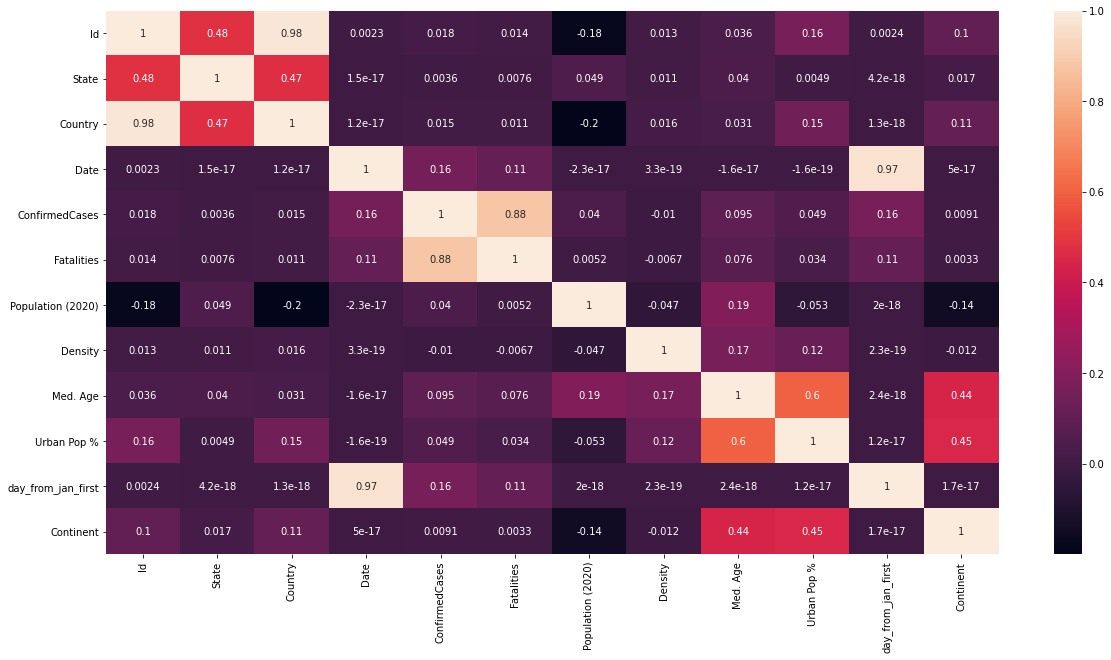

In [69]:
corrMatrix = train_copy.corr()
plt.figure(figsize=(20,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [70]:
X=train_copy[['State', 'Country', 'Continent', 'day_from_jan_first', 'Population (2020)', 'Density', 'Med. Age', 'Urban Pop %']]

In [71]:
y1=train_copy["ConfirmedCases"] #Confirmed Case
y2=train_copy["Fatalities"]     #Fatalities

In [72]:
#Confirmed Cases
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(X, y1, test_size = .20, random_state = 42)

In [73]:
#scaler = MinMaxScaler()
#X_train_confirmed = scaler.fit_transform(X_train_confirmed)
#X_test_confirmed = scaler.transform(X_test_confirmed)

In [74]:
dt1=DecisionTreeRegressor(criterion="friedman_mse",max_depth=20,random_state=42)

In [75]:
dt1.fit(X_train_confirmed, y_train_confirmed)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [76]:
y_pred_dt_confirmed=dt1.predict(X_test_confirmed)

In [77]:
np.sqrt(mean_squared_log_error( y_test_confirmed, y_pred_dt_confirmed ))

0.3554352873543635

In [78]:
#Fatalities
X_train_fatal, X_test_fatal, y_train_fatal, y_test_fatal = train_test_split(X, y2, test_size = .20, random_state = 42)

In [79]:
#scaler1 = MinMaxScaler()
#X_train_fatal = scaler1.fit_transform(X_train_fatal)
#X_test_fatal = scaler1.transform(X_test_fatal)

In [80]:
dt2=DecisionTreeRegressor(criterion="friedman_mse",max_depth=20,random_state=42)

In [81]:
dt2.fit(X_train_fatal, y_train_fatal)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [82]:
y_pred_dt_fatal=dt2.predict(X_test_fatal)

In [83]:
np.sqrt(mean_squared_log_error( y_test_fatal, y_pred_dt_fatal ))

0.19068492594882097

In [84]:
test_copy.head()

,ForecastId,State,Country,Date,Population (2020),Density,Med. Age,Urban Pop %,day_from_jan_first,Continent
0,1,0,0,20200402,38728504.0,60.0,18,0.25,93,1
1,2,0,0,20200403,38728504.0,60.0,18,0.25,94,1
2,3,0,0,20200404,38728504.0,60.0,18,0.25,95,1
3,4,0,0,20200405,38728504.0,60.0,18,0.25,96,1
4,5,0,0,20200406,38728504.0,60.0,18,0.25,97,1


In [85]:
X_test=test_copy[['State', 'Country', 'Continent', 'day_from_jan_first','Population (2020)', 'Density', 'Med. Age', 'Urban Pop %']]

In [86]:
#scaler2 = MinMaxScaler()
#X_test = scaler2.fit_transform(X_test)

In [87]:
y_confirmed=dt1.predict(X_test)

In [88]:
y_fatal=dt2.predict(X_test)

In [89]:
submission=pd.DataFrame({'ForecastId': test_copy["ForecastId"], 'ConfirmedCases': y_confirmed, 'Fatalities': y_fatal})

In [90]:
submission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,364.0,14.0


In [91]:
submission.to_csv('submission.csv', index=False)